In [1]:
%matplotlib inline

# Module 13 - Programming Assignment

## Directions

1. Change the name of this file to be your JHED id as in `jsmith299.ipynb`. Because sure you use your JHED ID (it's made out of your name and not your student id which is just letters and numbers).
2. Make sure the notebook you submit is cleanly and fully executed. I do not grade unexecuted notebooks.
3. Submit your notebook back in Blackboard where you downloaded this file.

*Provide the output **exactly** as requested*

# The Problem

When we last left our agent in Module 4, it was wandering around a world filled with plains, forests, swamps, hills and mountains. This presupposes a map with known terrain:

```
......
...**.
...***
..^...
..~^..
```

but what if all we know is that we have some area of interest, that we've reduced to a GPS grid:

```
??????
??????
??????
??????
??????
```

and the agent has to determine what kind of terrain is to the left, front and right of it?

Assuming the agent has a very simple visual sensor that constructs a 4x4 grayscale image for each of the three directions, it might it could see something like this:

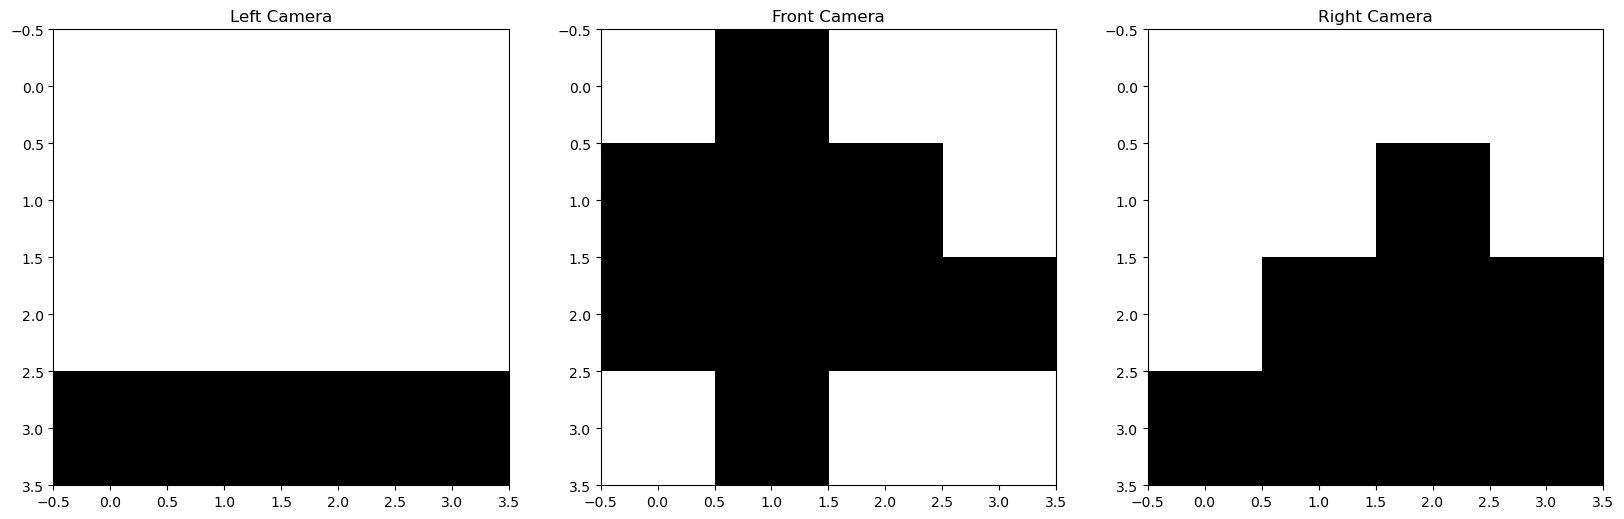

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

plain =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0,1.0, 1.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0,0.0, 1.0, 0.0, 0.0]
hills =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 1.0, 0.0,0.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0]
swamp =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 0.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Left Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Front Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Right Camera")
axes.imshow(pixels, cmap='gray')

plt.show()
plt.close()

which would be plains, forest and hills respectively.


## The Assignment

In Assignment 12, we applied a logistic regression to determine if something was "hills" or "not hills". For this programming assignment your task is to write an artificial neural network that determines what kind of terrain it is. This is a multi-class problem.

For a starting point, you can refer to Pseudocode and the Self-Check.

## Data

As before, we have clean examples of the different types of terrain but based on the location, the registration can be a bit off for some of the types and the visual sensor is often blurry.

Here are the clean examples with different registrations: 

In [3]:
clean_data = {
    "plains": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]
    ],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"]
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"]
    ],
    "swamp": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]        
    ]
}

Let's create a function that allows us to view any of these:

In [4]:
def view_sensor_image( data):
    figure = plt.figure(figsize=(4,4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype='uint8')
    pixels = pixels.reshape((4, 4))
    axes.set_title( "Left Camera:" + data[-1])
    axes.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

"I think that I shall never see a thing so lovely as a tree."

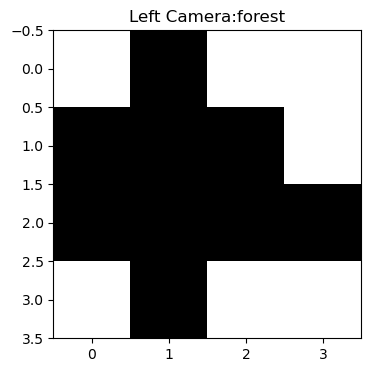

In [5]:
view_sensor_image( clean_data[ "forest"][0])

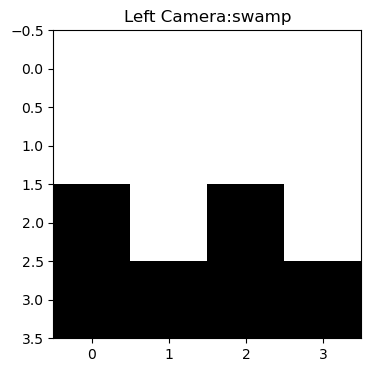

In [6]:
view_sensor_image( clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [7]:
def blur( data):
    def apply_noise( value):
        if value < 0.5:
            v = random.gauss( 0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss( 0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v
    noisy_readings = [apply_noise( v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

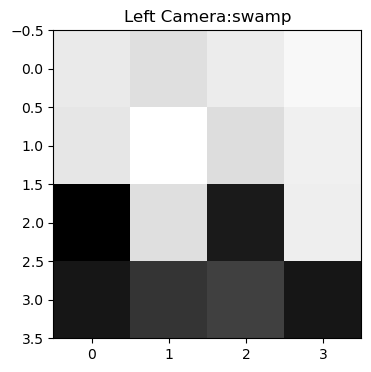

In [8]:
view_sensor_image( blur( clean_data["swamp"][0]))

You are going to want to write four (4) functions:

1. `generate_data`
2. `learn_model`
3. `apply_model`

### `generate_data`

With the clean examples and the `blur` function, we have an unlimited amount of data for training and testing our classifier, an ANN that determines if a sensor image is hills, swamp, forest or plains.

In classification, there is a general problem called the "unbalanced class problem". In general, we want our training data to have the same number of classes for each class. This means you should probably generate training data with, say, 100 of each type.

But what do we do about the class label with the neural network?

In this case, we can do "one hot". Instead of `generate_data` outputing a single 0 or 1, it should output a vector of 0's and 1's so that $y$ is now a vector as well as $x$. We can use the first position for hill, the second for swamp, the third for forest and the fourth for plains:

```
[0, 1, 0, 0]
```

what am I? swamp.

Unlike logistic regression, you should set the *biases* inside the neural network (the implict $x_0$ = 1) because there are going to be lot of them (one for every hidden and output node).

`generate_data` now only needs to take how many you want of each class:

`generate_data( clean_data, 100)`

generates 100 hills, 100 swamp, 100 forest, 100 plains and transforms $y$ into the respective "one hot" encoding. You can use the code from Module 12 as a starting point.

### `learn_model`

`learn_model` is the function that takes in training data and actually learns the ANN. If you're up to it, you can implement a vectorized version using Numpy but you might start with the loopy version first.

*In the lecture, I mentioned that you usually should mean normalize your data but you don't need to do that in this case because the data is already on the range 0-1.*

You should add a parameter to indicate how many nodes the hidden layer should have.

When verbose is True, you should print out the error so you can see that it is getting smaller.

When developing your algorithm, you need to watch the error so you'll set verbose=True to start. You should print it out every iteration and make sure it is declining. You'll have to experiment with both epsilon and alpha; and it doesn't hurt to make alpha adaptive (if the error increases, make alpha = alpha / 10).

When you know that your algorithm is working, change your code so that the error is printed out only every 1,000 iterations (it takes a lot of iterations for this problem to converge, depending on your parameter values--start early).

`learn_model` returns the neural network. The hidden layer will be one vector of thetas for each hidden node. And the output layer will have its own thetas, one for each output (4 in this case). Return it as a Tuple: (List of List, List of List).

### `apply_model`

`apply_model` takes the ANN (the model) and either labeled or unlabeled data. If the data is unlabeled, it will return predictions for each observation as a List of Tuples of the inferred value (0 or 1) and the actual probability (so something like (1, 0.73) or (0, 0.19) so you have [(0, 0.30), (1, 0.98), (0, 0.87), (0, 0.12)]. Note that unlike the logistic regression, the threshold for 1 is not 0.5 but which value is largest (0.98 in this case).

If the data is labeled, you will return a List of List of Tuples of the actual value (0 or 1) and the predicted value (0 or 1). For a single data point, you'll have the pairs of actual values [(0, 1), (0, 0), (0, 0), (1, 0)] is a misclassification and [(0, 0), (0, 0), (1, 1), (0, 0)] will be a correct classification. Then you have a List of *those*, one for each observation.

###  simple evaluation

We have an "unlimited" supply of data so we'll just generate a training set and then a test set and see how well our neural network does. Use the error rate (incorrect classifications/total examples) for your evaluation metric. We'll learn about more sophisticated 

1. generate training set (how many do you think you need?)
2. generate test set (how many is a good "test" of the network you built?)
3. loop over [2, 4, 8] hidden nodes:
    1. train model and apply to train data, calculate error rate.
    2. apply to test data and calculate error rate.
    3. print error rate
    
Which number of hidden nodes did best?

**As always when working with Lists or Lists of Lists, be very careful when you are modifying these items in place that this is what you intend (you may want to make a copy first)**

In [9]:
test_data = [([0.14916206519062947, 0.12286379066836, 0.0997380209652154, 0.0371293414275799, 0.11633839005152724, 0.6839114631524474, 0.1449115694968115, 0.015072580966834323, 0.7204410606779772, 1.0, 0.9348228550072025, 0.036900164643588196, 0.7690931696237476, 0.7942033984657938, 0.7894186656815813, 0.9253449229021087], [1, 0, 0, 0]), ([0.11839089995370881, 0.08197193130464517, 0.08616019843597349, 0.04845236750824951, 0.13164230874477645, 0.11084929271490403, 0.08424455812106699, 0.10802746505539051, 0.031221455996444283, 1.0, 0.1423661575652539, 0.9323549721235707, 1.0, 1.0, 1.0, 0.9490168822984151], [0, 1, 0, 0]), ([0.10502626749337979, 0.18770918150600008, 0.09930895706142252, 0.07651866994696718, 0.13049592641370839, 0.20102261356649925, 0.1812334770540903, 0.027955219633639977, 0.004057674795080055, 0.025623088376026698, 0.09422200711150315, 0.06278376555085344, 0.8899029925839775, 1.0, 0.9896188253034793, 1.0], [0, 0, 0, 1]), ([0.14779993113703072, 0.09654417657494715, 0.07556671928693347, 0.18652535538928128, 0.08439847610577028, 0.12077320952785939, 0.05263510379819389, 0.10729443766169845, 0.12003423352483551, 0.1465280397961382, 0.17488256528316654, 0.08488777970587455, 1.0, 0.7106531534217372, 0.8841487552841862, 0.9770469115025994], [0, 0, 0, 1]), ([0.14409558858483693, 0.15340547775897576, 0.10372145730468472, 0.8675962182374851, 0.10209536359132508, 0.1425921705755903, 0.8002040758350465, 0.9604944601547507, 0.10827788323082577, 0.8713426388495485, 0.7893140777356225, 0.8827344629486984, 0.03925931186788639, 0.05879050968671906, 0.19583334089612459, 0.916268464142276], [0, 0, 1, 0]), ([0.15763264178051503, 0.15612808675037754, 0.15951083692691673, 0.12127529433960825, 0.9331839152499268, 0.09791419430676526, 0.011833729958214648, 0.04379935581861302, 0.700042238757454, 1.0, 0.11276013310349478, 0.1403011536476693, 0.7985191387954786, 0.965508041148756, 0.7408306415369101, 0.10228049495402035], [1, 0, 0, 0]), ([0.04005933914646536, 0.8416572249191793, 0.0, 0.11119749222596152, 0.8804582362467572, 0.7584894640416845, 1.0, 0.07169713605455559, 0.932360851314044, 0.7330624857919839, 0.9260826162657856, 0.9272047465162325, 0.0977838528506637, 0.957684846910733, 0.08483804491384714, 0.07348010144794091], [0, 0, 1, 0]), ([0.09988370682401183, 0.10128883039613754, 0.16793973402717666, 0.05934025900545527, 0.07932782760130279, 0.08047765705031945, 0.218322848431417, 0.08837884481731564, 0.1749382860647909, 0.14059400994983232, 0.126911250948605, 0.05016202120707873, 0.8946794869891936, 1.0, 0.9239570197241295, 1.0], [0, 0, 0, 1]), ([0.047280066877560145, 0.06902377541034452, 0.22394292802733462, 0.10319409434699066, 0.14944720693007388, 0.03377268991904689, 1.0, 0.14753140490605995, 0.05361951928991196, 0.8283221017384832, 1.0, 1.0, 0.8873415664571563, 0.8848661895029469, 0.99421547147487, 0.9727718071592241], [1, 0, 0, 0]), ([0.9226039451636976, 0.12325008203635457, 0.07913820142386706, 0.06779518972394005, 1.0, 0.9948540808326131, 0.21201627116722677, 0.15464249318872006, 0.9385096162063459, 0.8788710699997964, 0.9063603429717604, 0.02321602835488136, 0.9583979227810983, 0.06956645876472065, 0.06317300632055328, 0.1258044710264009], [0, 0, 1, 0]), ([0.060199401263217656, 0.14426808384863296, 0.09409810379756128, 0.12241453548154302, 0.026026887458849624, 0.08405001602420045, 0.030758645119633707, 0.7922569128367225, 0.13262818955028466, 0.09716401330750045, 0.9547111778956178, 0.8382280368793398, 0.15643384404918892, 0.7866515223422524, 1.0, 0.9072028600533762], [1, 0, 0, 0]), ([0.05368136504689764, 0.10312413591342168, 0.1355273751510592, 0.0, 0.1139280244856406, 0.11502992119332325, 0.13202905984385027, 0.10198854564056743, 0.1981494789781089, 0.7787983720193199, 0.2004098389482125, 0.9939169424957337, 1.0, 0.9968886087024283, 0.6668601891560159, 0.9806542530419736], [0, 1, 0, 0]), ([0.041457077108638773, 0.06283612068082081, 0.8838723129545605, 0.054472282752476654, 0.04926945289732337, 0.9211807448161303, 0.7759100344408625, 0.9373408931293657, 0.7842048124217674, 0.9688343896643729, 0.7729851937397196, 0.851801485523611, 0.04855896870901813, 0.09017279709667374, 0.9880317258141971, 0.10500288209758721], [0, 0, 1, 0]), ([0.08758448712581558, 0.1335610343471574, 0.14954797292849414, 0.08205343092285558, 0.13642550511254647, 0.1573629642684203, 0.12687756633437344, 0.10779719661352523, 0.10833294578479927, 0.03291986451978711, 0.029772792769437784, 0.10755539695410576, 0.7363465512037195, 1.0, 0.7726279527276974, 0.9020310292076461], [0, 0, 0, 1]), ([0.026867696701888336, 0.12650433570500225, 0.032952335376307415, 0.06779622042979931, 0.09528344723907219, 0.11245670101047608, 0.12285329228916754, 0.16997359914347882, 0.11290601083457298, 0.7950513247260731, 0.15254116117708397, 1.0, 1.0, 0.7987739815512105, 0.9923912624828809, 0.9686446848503798], [0, 1, 0, 0]), ([0.04740844400160014, 0.10936442152980588, 0.157803775186599, 0.18932244948596727, 0.08821231594160961, 0.06380831295647288, 0.9410276663186631, 0.011961268138933195, 0.019002361216384864, 0.8735128417008691, 0.8364722212024548, 0.9442672445495478, 0.9369645687195761, 1.0, 0.8779415684192852, 0.8966663451286555], [1, 0, 0, 0]), ([0.0174732779077741, 0.13509643447692177, 0.8583386674132246, 0.033128070866104656, 0.05123286036229974, 0.9206260159400284, 0.9036113790147752, 0.8277715494076389, 0.854132401349672, 0.8918031871003396, 0.9235334255794574, 0.7390640841376599, 0.1422669338788698, 0.07786351661334912, 0.912346103463732, 0.1145551929980455], [0, 0, 1, 0]), ([0.11047171391919028, 0.09593181468132522, 0.751011093540368, 0.031062858383235567, 0.06569815514850802, 0.9435118571853521, 0.9271857067162673, 0.9180990617639013, 0.900298642588673, 0.7883802140711984, 0.8402707400574538, 0.8756421424865126, 0.0920866163799609, 0.13107821727181035, 0.8284444822628402, 0.09270084517244603], [0, 0, 1, 0]), ([0.10256280503019613, 0.1064154677121931, 0.07720586941579378, 0.13170887833371647, 0.14376233717633422, 1.0, 0.12835965912420574, 0.14025975250074668, 0.8842645089908948, 0.9517813698708874, 0.7322135643196408, 0.07663196952794943, 0.8359369185404877, 0.8242998134561892, 0.9474050961576018, 0.955717573490418], [1, 0, 0, 0]), ([0.1698877895914669, 0.13070922402739074, 0.04140157972258386, 0.8398368041012646, 0.05003252930979296, 0.060875871252261515, 1.0, 0.7454669213541579, 0.1185725099100205, 0.8763604865082079, 1.0, 0.9850811081851859, 0.04558892370776885, 0.11835410967882226, 0.08196835213227999, 0.9456339167144738], [0, 0, 1, 0]), ([0.11888988644554675, 0.15448897970582248, 0.11611315112872629, 0.13394566328897706, 0.1368677451689428, 0.0956401562955061, 0.16861206732931255, 0.053767844489517845, 0.09737689053310246, 0.13196953946769083, 0.12577779821064702, 0.12628293861271744, 0.7982439027126543, 0.896001771566541, 0.8844421387041385, 0.8875024500132186], [0, 0, 0, 1]), ([0.21357238432506043, 0.12820112365130454, 0.10196468712678598, 0.12843839575472, 0.08177150358418246, 0.055239744290242726, 0.7945534802997549, 0.10534758566940752, 0.09514128401134682, 0.928327167421631, 0.8411558328364688, 1.0, 0.9476156204417353, 0.8770735196943474, 0.6165788030166883, 0.7344130933258001], [1, 0, 0, 0]), ([0.1419382984030984, 0.12728979945327207, 0.18184516733308836, 0.018094687897437775, 0.12633005152025345, 0.11361408559848622, 0.11336535557494151, 0.12195776785922474, 0.1383482310443111, 1.0, 0.1201648682666926, 0.7729128328704665, 0.8963996810973781, 1.0, 0.9072583082020238, 0.8331950412270611], [0, 1, 0, 0]), ([0.17168573917599889, 0.006795800739735042, 0.06699160164105719, 0.13434189011213415, 0.11378044578821284, 0.14735234145698467, 0.04935850687947642, 0.17682156675564925, 0.9921686107854361, 0.04387226382875238, 0.8214339966707163, 0.13535203542026672, 0.8231701899583461, 0.794620082851095, 0.9040753202019179, 0.8712838042913406], [0, 1, 0, 0]), ([0.12116773886269858, 0.04970558836810146, 0.1258601040798084, 0.09881673234745719, 0.967827816962452, 0.04655567839740339, 0.0137697398391078, 0.15876043780014032, 1.0, 0.7448471468977723, 0.1287875662585899, 0.20861951081967908, 0.9410877473800422, 0.9892124787359632, 0.800121863260469, 0.13920573036211356], [1, 0, 0, 0]), ([0.09887870678503721, 0.9735743529633768, 0.06863170913788497, 0.0369851911992172, 1.0, 0.8122329802084708, 0.7547902650744929, 0.12808087390566092, 0.8949680518859738, 0.8583286317949227, 0.9280817707687106, 0.9872539229426558, 0.13460481890152254, 0.8485579411678711, 0.028656878803890617, 0.1629440921363826], [0, 0, 1, 0]), ([0.15573904949350664, 0.13649550461607568, 0.12613166436398013, 0.15223681652871618, 0.11384437282887616, 0.04401587159665237, 0.10781269178626654, 0.0588650402464418, 0.14213827774708668, 0.09180185102552332, 0.1701054577936646, 0.14270088938592498, 0.848079802492477, 0.9628355382522631, 1.0, 0.8605106004473443], [0, 0, 0, 1]), ([0.06995633076097749, 0.073251941998145, 0.1439489197140177, 0.09537771063251044, 0.12965891661115037, 0.032461202780421416, 0.10147598071480853, 0.12871476833361933, 0.17258102956358257, 0.11173436551098072, 0.08532474834873194, 0.07909964197205452, 0.9290172228474315, 0.9889235815077138, 0.9661848635192033, 0.8186518861744518], [0, 0, 0, 1]), ([0.18084578291258552, 0.09549368945620092, 0.033996638127860065, 0.17567954841469732, 0.09811497205064472, 0.18327155292915998, 0.098690982744491, 0.0561324801771112, 0.13638178178080518, 0.8909353795095829, 0.12456480118206575, 0.9161400588371462, 0.9861664641746797, 0.9128326511359489, 0.9642691531593155, 0.8866372809880787], [0, 1, 0, 0]), ([0.096557222891497, 0.10117607174465969, 0.19999913607439235, 0.04789405650354709, 0.09011067732514783, 0.14448231088450075, 0.2160041888841979, 0.04691378857031156, 0.07955150187115492, 0.7683116625505504, 0.13497445998117302, 0.8204343946012607, 0.9539254341372169, 0.8689279782421675, 1.0, 0.8324569056212484], [0, 1, 0, 0]), ([0.03170541958213058, 0.047197311442661496, 0.15494325208363033, 0.0896758595224309, 0.18385919548914387, 0.04949931463595636, 0.029372304271469876, 0.06726809223447017, 0.18907954290094486, 0.021180824614524696, 0.06755512101447689, 0.0765698448119857, 0.9708475255369543, 0.9777508023580472, 0.8274108521383854, 1.0], [0, 0, 0, 1]), ([0.0, 0.136276477944982, 0.06253262476096982, 0.04719073961636658, 0.1269272444485782, 0.08077996101482628, 0.05866281554815381, 0.7675670249609505, 0.11389852969934655, 0.05491263195719936, 0.6929815324914296, 1.0, 0.11111035513446749, 0.8697935295935967, 0.9462110108666411, 0.9745925319119763], [1, 0, 0, 0]), ([0.10468343378242698, 0.8318543588272841, 0.04055368218775771, 0.08982119304146796, 0.7615287394949922, 0.9423972296127128, 0.9924981995262422, 0.13286346934350546, 0.7943527014217387, 0.9145950079448539, 0.771450406097938, 0.884836479577113, 0.0909732404052776, 0.9297148838701143, 0.04514722427524447, 0.06472682481125475], [0, 0, 1, 0]), ([0.09571423256900378, 0.1657163313642122, 0.10393165305910262, 0.14366073355555425, 0.9510665527878384, 0.0892799463200456, 0.1279827882940419, 0.019988742767983417, 0.7533462129154163, 1.0, 0.10297072913806624, 0.07262988652726571, 0.8180687006731846, 0.8149932454268018, 0.9108228351785835, 0.09383131619391849], [1, 0, 0, 0]), ([0.0846997836817622, 0.14252785606252102, 0.07654673853271016, 0.2149141182438853, 0.14410994225294174, 0.1277098986319964, 0.09464475695981478, 0.07556031426681278, 0.09640740107294783, 0.14761949720961726, 0.1458761739130394, 0.0774671240780643, 0.7738241251513769, 0.8215639755969667, 0.9679676798285607, 0.9408699254350567], [0, 0, 0, 1]), ([0.16005696870362376, 0.0, 0.0775126823314608, 0.08499208279981532, 0.08267845553216419, 0.1017664371634203, 0.05372361928820113, 0.06210625028950903, 0.8753157201871469, 0.11424820892251232, 0.838285393941446, 0.11780781757725729, 0.8433508383690616, 0.9523566749142234, 0.8553310228319877, 0.7847679807443756], [0, 1, 0, 0]), ([0.1992671379907878, 0.1521576593421503, 0.10067124514694303, 0.21452585675661692, 0.15634514752968937, 0.07435266048966305, 0.07965651643703586, 0.1117570413356254, 0.11762654949986018, 0.8795051006430832, 0.05207164819767051, 0.6537501890394756, 0.821858493873675, 0.8176499774959473, 0.8665002864620649, 1.0], [0, 1, 0, 0]), ([0.09742267876131111, 0.02600061767441464, 0.1061834083230197, 0.15285678638160638, 0.14713213047239881, 0.0648900307235336, 0.0, 0.15423888300703625, 0.9049775405858799, 0.10489592961273844, 0.8231138663471278, 0.16588899746230967, 0.7723692960613799, 0.9984115249633088, 0.7928863332267257, 0.8255751363192978], [0, 1, 0, 0]), ([0.7098258025857219, 0.1326371086099017, 0.1373803903717477, 0.08981161789932851, 1.0, 0.6905006400958267, 0.13420933294791823, 0.025075887360161905, 0.947389096501347, 0.9239502661486805, 0.9865479791634235, 0.09331181734717149, 0.9545482886705005, 0.16400566935409527, 0.09534882000852898, 0.11548642306038509], [0, 0, 1, 0]), ([0.15075200722884863, 0.12751218602913084, 0.10768013219986004, 0.13929358070623765, 0.08585013975009625, 0.03992774525650847, 0.12701245276677883, 0.12584087022760487, 0.17506293302106232, 0.021406107369631083, 0.1258189713764447, 0.05682888829972081, 0.8864007457539902, 0.8248664857796713, 0.8347580913392596, 0.8851728161881808], [0, 0, 0, 1])]

In [10]:
from copy import deepcopy
from math import exp, log10

## Helper Functions

### dot

`dot` is a helper function that computes the dot product of the two input vectors. The dot product is the sum of products of each element pair in the two vectors:
$$ dot(x, y) = \sum_i x_i*y_i $$

**Used by**: [feed_forward](#feed_forward), [calculate_dHs](#calculate_dHs)

* **vec1**: the first vector in the dot product
* **vec2**: the second vector in the dot product

**returns** `float`: the dot product as a float

In [11]:
def dot(vec1, vec2):
    if len(vec1) != len(vec2): return None
    return sum(x1*x2 for x1,x2 in zip(vec1, vec2))

In [12]:
# assertions/unit tests
v1 = [1, 2, 3]
v2 = [3, 2, 1]
assert dot(v1, v2) == 10

v1 = [1, 2, 3, 4, 5]
v2 = [1, 2, 3, 4, 5]
assert dot(v1, v2) == 55

v1 = [1, 2]
v2 = [1, 2, 3]
assert dot(v1, v2) == None

### feed_forward

`feed_forward` is the method by which the neural network obtains values for hidden nodes and output nodes - the function propagates the inputs from `obs` forward using the `theta_hs` ($\theta$ values for the hidden layer as a list) to the hidden node layer. Then, the hidden node values are used as inputs along with `theta_os` ($\theta$ values for the ouptut layer as a list) to calculate the output values. Then, the function returns the new hidden node and output node values. This function is *destructive* and mutates both `hiddens` and `outputs`.

The feed-forward step is how the neural network learns the error in the current iteration - by comparing the outputs to the expected label, the network can calculate the $\delta^o$ and $\delta^h$ values to propagate backwards in the back-propagation step. Additionally, the function is used in `apply_model` to determine what the outputs are for each observation given the model (`theta_hs` and `theta_os`). **Used by**: [learn_model](#learn_model), [apply_model](#apply_model).

* **theta_hs**: a list of hidden layer thetas
* **theta_os**: a list of output layer thetas
* **hiddens**: a list of hidden node values to be overwritten
* **outputs**: a list of output node values to be overwritten
* **obs**: a list of input values ($x_i$'s)

**returns** `Tuple`: a tuple of hidden values as a list and output values as a list

In [13]:
def feed_forward(theta_hs, theta_os, hiddens, outputs, obs):
    for i, hidden_node in enumerate(hiddens):
        theta_x = dot(theta_hs[i], obs)
        hiddens[i] = 1 / (1 + exp(-theta_x))
    for j, output_node in enumerate(outputs):
        theta_x = dot([1] + hiddens, theta_os[j])
        outputs[j] = 1 / (1 + exp(-theta_x))
    return hiddens, outputs

In [14]:
# assertions/unit tests
theta_hs = [[0.01, 0.26, -0.42], [-0.05, 0.78, 0.19], [0.42, -0.23, 0.37]]
theta_os = [[0.2, 0.61, 0.12, -0.9], [0.3, 0.28, -0.34, 0.1]]
hiddens = [0] * 3
outputs = [0] * 2
hiddens_copy = deepcopy(hiddens)
obs = [1, 0.52, -0.97]

hiddens, outputs = feed_forward(theta_hs, theta_os, hiddens, outputs, obs)
assert abs(hiddens[0] - 0.635) < 0.005
assert abs(hiddens[1] - 0.543) < 0.005
assert abs(hiddens[2] - 0.485) < 0.005
assert abs(outputs[0] - 0.553) < 0.005
assert abs(outputs[1] - 0.585) < 0.005
assert hiddens != hiddens_copy

### calculate_dOs

`calculate_dOs` calculates the $\delta^o$ values to be used in the back-propagation. These are the direct error between the expected `label` and the estimated `outputs`. The formula for the ith output delta is:

$$ \delta^o_i = \hat{y}_i(1 - \hat{y}_i)(y_i - \hat{y}_i) $$

The function computes one $\delta^o$ value for each output node and returns them in a list. These values are then used in updating the $\theta$ values, as well as the computation of $\delta^h$ as the error is propagated backwards. **Used by**: [learn_model](#learn_model)

* **outputs**: the estimated output values
* **labels**: the actual label values

**returns** `List`: a list of $\delta^o$ values for each output

In [15]:
def calculate_dOs(outputs, labels):
    dOs = []
    for yhat, y in zip(outputs, labels):
        dO = yhat*(1 - yhat)*(y - yhat)
        dOs.append(dO)
    return dOs

In [16]:
# assertions/unit tests
outputs = [0.553, 0.585]
outputs_copy = deepcopy(outputs)
labels = [1, 0]
dOs = calculate_dOs(outputs, labels)
assert abs(dOs[0] - 0.110) < 0.005
assert abs(dOs[1] - (-0.142)) < 0.005
assert outputs == outputs_copy

### calculate_dHs

`calcluate_dHs` computes the propagated error from the $\delta^o$ values. This error is the weighted error of each hidden node's contribution to the error in each output node - in other words, each $\delta^h_i$ represents the ith hidden node's contribution to the error. The formula is:

$$ \delta^h_i = (\hat{y}_i)(1 - \hat{y}_i)\sum_j \theta^{o, j}\delta^{o, j} $$

Here, i represents the ith hidden node and j represents the jth output node - each hidden node computes the weighted sum of errors to each output node, with the weights as the $\theta$ values between the hidden node and each output node. These deltas are used in computing the new $\theta$ values for the next iteration. **Used by**: [learn_model](#learn_model).

* **hiddens**: the values of each hidden node
* **theta_os**: a list of output layer thetas
* **dOs**: a list of $\delta^o$ values

**returns** `List`: a list of $\delta^h$ values

In [17]:
def calculate_dHs(hiddens, theta_os, dOs):
    dHs = []
    for i, yhat in enumerate(hiddens):
        curr_thetas = [theta_o[i + 1] for theta_o in theta_os]
        dH = yhat*(1 - yhat)*dot(curr_thetas, dOs)
        dHs.append(dH)
    return dHs

In [18]:
# assertions/unit tests
hiddens = [0.635, 0.543, 0.485]
theta_os = [[0.2, 0.61, 0.12, -0.9], [0.3, 0.28, -0.34, 0.1]]
dOs = [0.110, -0.142]
dHs = calculate_dHs(hiddens, theta_os, dOs)
assert abs(dHs[0] - 0.0063) < 0.00005
assert abs(dHs[1] - 0.0153) < 0.00005
assert abs(dHs[2] - (-0.0283)) < 0.00005

### update_thetas

`update_thetas` updates the current list of output and hidden layer theta values according to the calculated $\delta^o$ and $\delta^h$ lists. The formula for a new $\theta$ is:

$$ \theta_j = \theta_j + \alpha \delta^i x_j $$


Here, j is the jth theta value in the current layer, $\alpha$ is the learning rate, $\delta^i$ is the ith delta from the next layer, and $x_j$ is the jth input from the previous layer. For the output layer, this means that the $\delta^i$ term is the $\delta^{o, i}$ corresponding to the ith output node's $\delta$ to the jth hidden node, and $x_j$ would be the value of the jth hidden node. For the hidden layer, this means the $\delta^i$ term is the $\delta^{h, i}$ corresponding to the ith hidden node's $\delta$ to the jth input node, and $x_j$ is the value of the jth input node. This function is *destructive* and modifies the `theta_hs` and `theta_os` in place.

This is the method by which the neural network learns and updates iteration to iteration. The learning rate is a crucial hyperparameter - lower learning rates can result in extremely slow execution, and higher learning rates can result in non-convergence. **Used by**: [learn_mode](#learn_model).

* **theta_hs**: a list of hidden layer thetas to be updated
* **theta_os**: a list of output layer thetas to be updated
* **alpha**: the learning rate
* **dOs**: the delta values from the output layer
* **dHs**: the delta values from the hidden layer
* **hiddens**: a list of the hidden node values
* **obs**: a list of input values

**returns** `Tuple`: a tuple of the updated hidden and output layer thetas

In [19]:
def update_thetas(theta_hs, theta_os, alpha, dOs, dHs, hiddens, obs):
    theta_os_copy = deepcopy(theta_os)
    for i, dO in enumerate(dOs):
        for j, hidden in enumerate([1] + hiddens):
            d_theta = alpha * dOs[i] * hidden
            theta_os[i][j] = theta_os[i][j] + d_theta
    for i, dH in enumerate(dHs):
        for j, x in enumerate(obs):
            d_theta = alpha * dHs[i] * x
            theta_hs[i][j] = theta_hs[i][j] + d_theta
    return theta_hs, theta_os

In [20]:
# assertions/unit tests
theta_hs = [[0.01, 0.26, -0.42], [-0.05, 0.78, 0.19], [0.42, -0.23, 0.37]]
theta_os = [[0.2, 0.61, 0.12, -0.9], [0.3, 0.28, -0.34, 0.1]]
alpha = 0.01
dOs = [0.110, -0.142]
dHs = [0.0063, 0.0153, -0.0283]
hiddens = [0.635, 0.543, 0.485]
obs = [1, 0.52, -0.97]

theta_hs, theta_os = update_thetas(theta_hs, theta_os, alpha, dOs, dHs, hiddens, obs)
assert abs(theta_os[0][0] - 0.2011) < 0.0005
assert abs(theta_os[0][1] - 0.6106) < 0.0005
assert abs(theta_os[0][2] - 0.1206) < 0.0005
assert abs(theta_os[0][3] - (-0.899)) < 0.0005

assert abs(theta_os[1][0] - 0.2986) < 0.0005
assert abs(theta_os[1][1] - 0.2791) < 0.0005
assert abs(theta_os[1][2] - (-0.3408)) < 0.0005
assert abs(theta_os[1][3] - 0.0993) < 0.0005

assert abs(theta_hs[0][0] - 0.0101) < 0.0005
assert abs(theta_hs[0][1] - 0.2600) < 0.0005
assert abs(theta_hs[0][2] - (-0.4201)) < 0.0005

assert abs(theta_hs[1][0] - (-0.0498)) < 0.0005
assert abs(theta_hs[1][1] - 0.7800) < 0.0005
assert abs(theta_hs[1][2] - 0.1899) < 0.0005

assert abs(theta_hs[2][0] - 0.4197) < 0.0005
assert abs(theta_hs[2][1] - (-0.2301)) < 0.0005
assert abs(theta_hs[2][2] - 0.3703) < 0.0005

### calculate_error

`calculate_error` is a helper function to calculate the error of the current iteration. It accumulates the error in the `curr_err` parameter. This function is *destructive* and modifies the `curr_err` parameter. The error is computed for each output in the current iteration's outputs and summed across all observations. The formula for one observation with $i$ outputs is:
$$ err = \sum_i (y_i\log{\hat{y}_i}) + (1 - y_i)(\log(1 - \hat{y}_i))$$
This cumulative error is then averaged over all observations to be used in modifying the learning rate. **Used by** [learn_model](#learn_model).

* **curr_err**: the current cumulative error
* **output**: the current observation's estimated label
* **label**: the current observation's actual label

**returns** `float`: the cumulative error

In [21]:
def calculate_error(curr_err, output, label):
    for yhat, y in zip(output, label):
        curr_err += (y*log10(yhat)) if yhat != 0 else 0
        curr_err += (1 - y)*log10(1 - yhat) if yhat != 1 else 0
    return curr_err

In [22]:
curr_err = 0
output = [0.553, 0.585]
label = [0, 1]
curr_err = calculate_error(curr_err, output, label)
assert abs(curr_err - (-0.582)) < 0.005

prev_err = deepcopy(curr_err)
output = [0.7511, 0.6367]
label = [1, 0]
curr_err = calculate_error(curr_err, output, label)
assert abs(curr_err - (-1.147)) < 0.005
assert abs(curr_err) > abs(prev_err)

## Main Functions

### generate_data

Generates an endless supply of blurred data from a collection of terrain prototypes.

* `data`: Dict[Str, List[Any]] - a Dictionary of "clean" prototypes for each landscape type.
* `n`: Int - the number of blurred examples of each terrain type to return.

returns

* List[List[Any]] - a List of Lists. Each individual List is a blurred example of a terrain type, generated from the prototype.

In [23]:
def generate_data(data, n):
    labels = list(data.keys())
    result = []
    for i, label in enumerate(labels):
        for _ in range(n):
            datum = blur(random.choice(data[label]))
            xs = datum[0:-1]
            ys = [0] * len(labels)
            if label == "hills": ys[0] = 1; 
            if label == "swamp": ys[1] = 1; 
            if label == "forest": ys[2] = 1; 
            if label == "plains": ys[3] = 1;
            result.append((xs, ys))
    random.shuffle(result)
    return result

In [24]:
results = generate_data(clean_data, 10)
# for result in results:
#     print(result)

### learn_model

`learn_model` is the training of the neural network using feed-forward and back-propagation. The network is described by two lists of lists: one list of $\theta^h$ values representing the weights of edges between input and hidden nodes, and one list of $\theta^o$ values representing weights of edges between hidden and output nodes. Each row represents the parent node and each column represents the child node - for `theta_hs`, the first list is theta values for all edges from the first input to every hidden node. These thetas are returned as the model at the end of training.

Before training, the data is augmented to prepend a constant value of 1 for `x_0`. The convergence criteria is a static limit of iterations, `limit`. Error values are calculated at each iteration to determine whether the learning rate `alpha` should be decreased - if the error of two sequential iterations increases, `alpha` is divided by 10. The error is summed over all observations, and averaged at the end to find the average error per observation (rather than the average error per output node classification). In each iteration, the theta lists are updated once per observation ("stochastic" update) - this is different from the "batch" update done in Module 12's gradient descent algorithm. If the `verbose` flag is `True`, the error rate will be printed once every 1000 iterations. **Uses**: [feed_forward](#feed_forward), [calculate_dOs](#calculate_dOs), [calculate_dHs](#calculate_dHs), [update_thetas](#update_thetas), [calculate_error](#calculate_error).

* **data**: a list of observations and labels
* **hidden_nodes**: the number of nodes in the hidden layer
* **verbose**: an optional flag to print error rates every 1000 iterations

**returns** `List[List]]`: a list of thetas for the hidden layer and thetas for the output layer

In [25]:
def learn_model( data, hidden_nodes, verbose=False):
    theta_hs = [[random.uniform(-1, 1) for _ in range(len(data[0][0]) + 1)] for _ in range(hidden_nodes)]
    theta_os = [[random.uniform(-1, 1) for _ in range(hidden_nodes + 1)] for _ in range(len(data[0][1]))]
    hiddens, outputs = [0] * hidden_nodes, [0] * len(data[0][1])
    new_data = [([1] + obs, label) for obs, label in deepcopy(data)]
    epsilon, alpha, t, limit, n = 1e-7, 0.1, 1, 3000, len(data)
    prev_err, curr_err = 0, 1
    while t < limit:
        t, prev_err, curr_err = t + 1, curr_err, 0
        if curr_err > prev_err: alpha = alpha / 10
        for obs, label in new_data:
            hiddens, outputs = feed_forward(theta_hs, theta_os, hiddens, outputs, obs)
            dOs = calculate_dOs(outputs, label)
            dHs = calculate_dHs(hiddens, theta_os, dOs)
            theta_hs, theta_os = update_thetas(theta_hs, theta_os, alpha, dOs, dHs, hiddens, obs)
            curr_err = calculate_error(curr_err, outputs, label)
        curr_err = curr_err / (-n)
        if verbose and t % 1000 == 0: print("Error:", curr_err)
    return [theta_hs, theta_os]

### apply_model

`apply_model` takes a model (two lists of thetas) and a test set and returns a list of classifications for each observation in the test set. If the data is labeled (per the `labeled` flag), the classifications are tuples where the first element is the actual label and the second is the estimated label. The estimated label is chosen based on the softmax of the outputs of the neural network - if the output is [0.997, 0.5, 0.3, 0.8] and the label is [1, 0, 0, 0], the the classification will be [(1, 1), (0, 0), (0, 0), (0, 0)]. The list of results is then a list of lists of tuples for each label in each observation.

If the data is unlabeled, the function returns a list of classifications where each classification is a list of tuples. Each tuple's first element is the estimate classification for *that output value only*. If the output is the softmax, the first element will be 1; otherwise, it is 0. The second element is the actual value of the output for each observation. If the output of the network is [0.997, 0.5, 0.3, 0.8], the classfication will be [(1, 0.997), (0, 0.5), (0, 0.3), (0, 0.8)].

**Uses**: [feed_forward](#feed_forward)

* **model**: a list of two lists of theta values for hidden and output layers
* **test_data**: a set of data to apply the model to
* **labeled**: an optional parameter denoting whether `test_data` contains labels or not

**returns** `List[Tuple]`: a list of tuples, with each tuple as a classification

In [26]:
def apply_model( model, test_data, labeled=False):
    results, theta_hs, theta_os = [], model[0], model[1]
    hiddens, outputs = [0] * len(theta_hs), [0] * len(theta_os)
    if labeled:
        new_data = [([1] + obs, label) for obs, label in deepcopy(test_data)]
        for obs, label in new_data:
            _, outputs = feed_forward(theta_hs, theta_os, hiddens, outputs, obs)
            result, max_label = [], max(outputs)
            for y, output in zip(label, outputs):
                new_res = (y, 1) if output == max_label else (y, 0); result.append(new_res)
            results.append((result))
    else:
        new_data = [([1] + obs) for obs in deepcopy(test_data)]
        for obs in new_data:
            _, outputs = feed_forward(theta_hs, theta_os, hiddens, outputs, obs)
            result, max_label = [], max(outputs)
            for output in outputs:
                new_res = (1, output) if output == max_label else (0, output); result.append(new_res)
            results.append((result))
    return results

Test out generate_data:

In [27]:
results = generate_data( clean_data, 10)
for result in results:
    print( result)

([0.12199374766283765, 0.07135018583300029, 0.11513401633811612, 0.16952474884733174, 0.09273676793620397, 0.14020498140653184, 0.06411431799963324, 0.012380380613896527, 0.0759659993056764, 0.0632686619639676, 0.05217561612721468, 0.08453549917813427, 0.709719350694464, 0.9834163633634063, 0.7565564219102996, 1.0], [0, 0, 0, 1])
([0.0030638154941639295, 0.9429657576075798, 0.14027788668831642, 0.08268622873903962, 0.8021403105307029, 0.8185551706344679, 0.9542824639696208, 0.09588821403891269, 0.9054424191942997, 0.809894923861999, 0.92920528890147, 0.9517378978911851, 0.11950542570678684, 0.6815100540909229, 0.15923684625435294, 0.11674390463873285], [0, 0, 1, 0])
([0.10016438989127308, 0.028285935239299523, 1.0, 0.1022401941044497, 0.0736239472158471, 0.7761797951766909, 0.9791187560093375, 0.8427163411652003, 0.9725257759712065, 0.905397641100751, 0.8817928901801552, 0.8346632318807586, 0.0746202027143711, 0.05801379153392952, 0.8119599672837512, 0.050824898047240205], [0, 0, 1, 0]

Use `generate_data` to generate 100 blurred examples of each type (all four terrains).

In [28]:
train_data = generate_data( clean_data, 100)

Use `learn_model` to learn a ANN model for classifying sensor images as hills, swamps, plains or forest. **Set Verbose to True**

In [29]:
model = learn_model( train_data, 2, True)

Error: 0.017459926364007866
Error: 0.011996531535136426
Error: 0.00967317546977165


Use `generate_data` to generate 100 blurred examples of each terrain and use this as your test data.

In [30]:
test_data = generate_data( clean_data, 100)

Apply the model and evaluate the results.

In [31]:
results = apply_model( model, test_data, True)

Now that you're pretty sure your algorithm works (the error rate during training is going down, and you can evaluate `apply_model` results for its error rate), you need to determine what the best number of hidden nodes is.

Try 2, 4, or 8 hidden nodes and indicate the best one. Follow the outline above under "Simple Evaluation".
In the "real world", you could 10 fold cross validation and validation curves to determine the number of hidden nodes and possibly if you needed one or two hidden layers.

In [32]:
node_range = [2, 4, 8]
train_data = generate_data( clean_data, 100)
test_data = generate_data( clean_data, 100)
n = len(test_data)
for num_hidden in node_range:
    model = learn_model( train_data, num_hidden)
    results = apply_model(model, test_data, True)
    error = 0
    for result in results:
        if any(yhat != y for y, yhat in result): error += 1
    print("Error rate for", num_hidden, "hidden nodes: ", (error/n))

Error rate for 2 hidden nodes:  0.0
Error rate for 4 hidden nodes:  0.0
Error rate for 8 hidden nodes:  0.0


which number of hidden nodes is best? 2

From the above evaluation, all three versions have an error rate of 0. This is to be expected, as the problem is relatively "easy" for the neural network to learn. However, the more hidden nodes there are, the longer the algorithm takes to run. Therefore, the best number of hidden nodes is that which has the lowest runtime and lowest error rate - this is 2 hidden nodes.

## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.